#### **0. References**
1. Diffusion model pipeline is adapted from [DDPM-Pytorch by ExplainingAI](https://github.com/explainingai-code/DDPM-Pytorch).
2. UNet code is based on Hugging Face Stable-Diffusion's U-Net implementaiton ( via diffusers package ).
3. FID computation code is adapted from [pytorch-fid by mseitzer](https://github.com/mseitzer/pytorch-fid).
4. **ChatGPT** for providing support, encouragement, and syntactically correct suggestions at 3 AM.

#### **1. Libraries**

In [2]:
## libraries ##
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid


from tqdm import tqdm
import yaml
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt


c:\Users\Admin\anaconda3\envs\ddpm-pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## GPU check and libraries version check ##
!nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
print( 'python version : ',sys.version) 
print( 'torch version  : ',torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

NVIDIA GeForce RTX 4070 Ti SUPER, 16376 MiB
python version :  3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
torch version  :  1.11.0


#### **2. Model utils**

**Denoising Diffusion Probabilistic Models (DDPM)**

DDPM is a generative model that learns to generate data (e.g., images) by reversing a gradual noising process.

1. Forward Process (Diffusion)
- Adds Gaussian noise to the image over T steps.
- At each step t, noise is added:
  ```
  q(x_t | x_{t-1}) = N(x_t; sqrt(1 - β_t) * x_{t-1}, β_t * I)
  ```
- After many steps, the image becomes pure noise.

2. Reverse Process (Denoising)
- Learns to reverse the noising process using a neural network.
- Predicts the original image (or the added noise) step-by-step:
  ```
  p_θ(x_{t-1} | x_t) = N(x_{t-1}; μ_θ(x_t, t), Σ_θ(x_t, t))
  ```

Neural Network (U-Net)
- A U-Net is typically used as the denoiser.
- Inputs: noisy image x_t and time step t.
- Outputs: predicted noise or clean image.
- Uses time embeddings to condition on step t.








In [5]:
## Forward and Reverse process ##

class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)
        
    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        
        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
        
        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the noise predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)
        
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
        
        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0


In [6]:
## time embedding ##
def get_time_embedding(time_steps, temb_dim):
    r"""
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    
    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(
        start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    )
    
    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb

In [7]:
## U-Net architecture ##
class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample using 2x2 average pooling
    """
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
             for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Attention block of Unet
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers+1)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers+1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers+1)
            ]
        )
    
    def forward(self, x, t_emb):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out)
            out = out + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out)
            out = out + self.residual_input_conv[i+1](resnet_input)
        
        return out


class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        return out


class Unet(nn.Module):
    r"""
    Unet model comprising
    Down blocks, Midblocks and Uplocks
    """
    def __init__(self, model_config):
        super().__init__()
        im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1
        
        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers))
        
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels)-1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                    self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers))
        
        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)
    
    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W
        
        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4
            
        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4
        
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out


#### **3. Dataset utils**

In [8]:
## Custom dataset ##

import torch    
from torch.utils.data import Dataset
import pathlib
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, target_dir, transform=None):
        self.paths = [ os.path.join(target_dir, x) for x in os.listdir(target_dir) if x.endswith('.npy')]
        # load all the paths of numpy images from the target directory    
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img_path = self.paths[index]
        img = np.load(img_path) # (1,150,150)     
        img = torch.tensor(img, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)
            
        return img 

#### **4. Training utils**

In [9]:
## Checkpoint saving and loading utils ##

def save_checkpoint(model, optimizer, epoch, losses, save_path="checkpoint.pth"):
    """
    Save the training state so you can resume later from this point.
    """
    checkpoint = {
        'epoch': epoch, # number of epochs completed
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses
    }
    torch.save(checkpoint, save_path)
    print(f"Checkpoint saved at '{os.path.relpath(save_path,os.getcwd())}' (epoch {epoch}).")

def load_checkpoint(model, optimizer, ckpt_path="checkpoint.pth"):
    """
    Load the training state so you can pick up exactly where you left off.
    """
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch_idx = checkpoint['epoch']
    losses = checkpoint['losses']
    print(f"Checkpoint loaded from '{os.path.relpath(ckpt_path,os.getcwd())}' ({start_epoch_idx} epochs completed).")
    return start_epoch_idx, losses


def plot_loss_vs_epoch(losses, save_path=None, dpi=300):
    
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, losses, 'o-', linewidth=2, markersize=6, label='Training Loss')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Loss vs. Epoch", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()

def set_seed(seed):
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # only applies to CUDA convolutional operation.
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # torch.use_deterministic_algorithms(True,warn_only=True)



In [10]:
## training loop definition ##  

def model_train(model,scheduler,data_loader,config,load_ckpt=False):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   
    diffusion_config = config['diffusion_params']
    train_config = config['train_params']   
    
    # Specify training parameters
    start_epoch_idx = 0
    num_epochs = train_config['num_epochs']
    optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])
    criterion = torch.nn.MSELoss()
    losses = []


    # Load checkpoint if found
    ckpt_path = os.path.join(train_config['task_name'],train_config['ckpt_name'])
    if load_ckpt and os.path.exists(os.path.join(ckpt_path)):
        start_epoch_idx,losses = load_checkpoint(model, optimizer, ckpt_path)
    

    print('\nStarting Training ...')  

    # Run training
    for epoch_idx in range(start_epoch_idx,num_epochs):
        local_losses = []
        for im in tqdm(data_loader):
            optimizer.zero_grad()
            im = im.float().to(device)

            # Sample random noise
            noise = torch.randn_like(im).to(device) # (B, C, H, W)
        
            # Sample timestep
            t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device) # (B,)
            
            # Add noise to images according to timestep
            noisy_im = scheduler.add_noise(im, noise, t)
            noise_pred = model(noisy_im, t)

            loss = criterion(noise_pred, noise)
            local_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        print('Finished epoch:{} | Loss : {:.4f}'.format(
            epoch_idx + 1,
            np.mean(local_losses),
        ))
        losses.append(np.mean(local_losses))
        save_checkpoint(model, optimizer, epoch_idx+1 , losses, 
                          os.path.join(train_config['task_name'],train_config['ckpt_name']))
        if (epoch_idx+1) % 10 == 0:
            save_checkpoint(model, optimizer, epoch_idx+1 , losses,
                            os.path.join(train_config['task_name'],train_config['ckpt_name'].split('.')[0]+'_epoch_'+str(epoch_idx+1)+'.pth'))  
            
    
    plot_loss_vs_epoch(losses, os.path.join(train_config['task_name'],'loss_vs_epoch.png')) 

    print('Done Training ...')

#### **5. TRAINING**

In [9]:
## config file ##
config_path = r'config\default.yaml'
set_seed( 100 )

with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

import torch
from torch.utils.data import DataLoader
from torchvision import transforms   
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print( f'Training on {device}')

diffusion_config = config['diffusion_params']
dataset_config = config['dataset_params']
model_config = config['model_params']
train_config = config['train_params']

# Create the noise scheduler
scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                    beta_start=diffusion_config['beta_start'],
                                    beta_end=diffusion_config['beta_end'])

# Create the dataset
transform = transforms.Compose([transforms.Resize((model_config['im_size'],model_config['im_size'])),
                                transforms.Lambda(lambda x: x * 2 - 1)]) # Normalize to [-1, 1] ( similar to DDPM paper )
train_dataset = CustomDataset(dataset_config['im_path'], transform=transform)  

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)

# Instantiate the model
model = Unet(model_config).to(device)
model.train()

# Create output directories
if not os.path.exists(train_config['task_name']):
    os.mkdir(train_config['task_name'])

# Train the model
model_train(model,scheduler,train_dataloader,config,load_ckpt=True)
torch.cuda.empty_cache()



Training on cuda

Starting Training ...


100%|██████████| 2250/2250 [05:37<00:00,  6.66it/s]


Finished epoch:1 | Loss : 0.0386
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 1).


100%|██████████| 2250/2250 [05:38<00:00,  6.65it/s]


Finished epoch:2 | Loss : 0.0083
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 2).


100%|██████████| 2250/2250 [05:35<00:00,  6.71it/s]


Finished epoch:3 | Loss : 0.0065
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 3).


100%|██████████| 2250/2250 [05:33<00:00,  6.75it/s]


Finished epoch:4 | Loss : 0.0057
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 4).


100%|██████████| 2250/2250 [05:32<00:00,  6.76it/s]


Finished epoch:5 | Loss : 0.0050
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 5).


100%|██████████| 2250/2250 [05:32<00:00,  6.78it/s]


Finished epoch:6 | Loss : 0.0052
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 6).


100%|██████████| 2250/2250 [05:30<00:00,  6.81it/s]


Finished epoch:7 | Loss : 0.0048
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 7).


100%|██████████| 2250/2250 [05:30<00:00,  6.80it/s]


Finished epoch:8 | Loss : 0.0046
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 8).


100%|██████████| 2250/2250 [05:31<00:00,  6.78it/s]


Finished epoch:9 | Loss : 0.0046
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 9).


100%|██████████| 2250/2250 [05:34<00:00,  6.73it/s]


Finished epoch:10 | Loss : 0.0047
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 10).
Checkpoint saved at 'exp-2\ddpm_ckpt_epoch_10.pth' (epoch 10).


100%|██████████| 2250/2250 [05:37<00:00,  6.66it/s]


Finished epoch:11 | Loss : 0.0045
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 11).


100%|██████████| 2250/2250 [05:39<00:00,  6.64it/s]


Finished epoch:12 | Loss : 0.0041
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 12).


100%|██████████| 2250/2250 [05:24<00:00,  6.93it/s]


Finished epoch:13 | Loss : 0.0045
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 13).


100%|██████████| 2250/2250 [05:28<00:00,  6.86it/s]


Finished epoch:14 | Loss : 0.0041
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 14).


100%|██████████| 2250/2250 [05:25<00:00,  6.92it/s]


Finished epoch:15 | Loss : 0.0041
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 15).


100%|██████████| 2250/2250 [05:28<00:00,  6.84it/s]


Finished epoch:16 | Loss : 0.0040
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 16).


100%|██████████| 2250/2250 [05:32<00:00,  6.78it/s]


Finished epoch:17 | Loss : 0.0042
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 17).


100%|██████████| 2250/2250 [05:27<00:00,  6.86it/s]


Finished epoch:18 | Loss : 0.0038
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 18).


100%|██████████| 2250/2250 [05:31<00:00,  6.78it/s]


Finished epoch:19 | Loss : 0.0040
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 19).


100%|██████████| 2250/2250 [05:35<00:00,  6.70it/s]


Finished epoch:20 | Loss : 0.0041
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 20).
Checkpoint saved at 'exp-2\ddpm_ckpt_epoch_20.pth' (epoch 20).


100%|██████████| 2250/2250 [05:30<00:00,  6.80it/s]


Finished epoch:21 | Loss : 0.0037
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 21).


100%|██████████| 2250/2250 [05:38<00:00,  6.65it/s]


Finished epoch:22 | Loss : 0.0038
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 22).


100%|██████████| 2250/2250 [05:36<00:00,  6.68it/s]


Finished epoch:23 | Loss : 0.0040
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 23).


100%|██████████| 2250/2250 [05:34<00:00,  6.72it/s]


Finished epoch:24 | Loss : 0.0040
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 24).


100%|██████████| 2250/2250 [05:35<00:00,  6.70it/s]


Finished epoch:25 | Loss : 0.0037
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 25).


100%|██████████| 2250/2250 [05:32<00:00,  6.78it/s]


Finished epoch:26 | Loss : 0.0041
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 26).


100%|██████████| 2250/2250 [05:34<00:00,  6.74it/s]


Finished epoch:27 | Loss : 0.0043
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 27).


100%|██████████| 2250/2250 [05:33<00:00,  6.76it/s]


Finished epoch:28 | Loss : 0.0036
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 28).


100%|██████████| 2250/2250 [05:33<00:00,  6.75it/s]


Finished epoch:29 | Loss : 0.0038
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 29).


100%|██████████| 2250/2250 [05:34<00:00,  6.72it/s]


Finished epoch:30 | Loss : 0.0036
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 30).
Checkpoint saved at 'exp-2\ddpm_ckpt_epoch_30.pth' (epoch 30).


100%|██████████| 2250/2250 [07:26<00:00,  5.04it/s]


Finished epoch:31 | Loss : 0.0036
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 31).


100%|██████████| 2250/2250 [07:43<00:00,  4.86it/s]


Finished epoch:32 | Loss : 0.0040
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 32).


100%|██████████| 2250/2250 [06:25<00:00,  5.83it/s]


Finished epoch:33 | Loss : 0.0038
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 33).


100%|██████████| 2250/2250 [05:34<00:00,  6.72it/s]


Finished epoch:34 | Loss : 0.0033
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 34).


100%|██████████| 2250/2250 [06:01<00:00,  6.22it/s]


Finished epoch:35 | Loss : 0.0038
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 35).


100%|██████████| 2250/2250 [06:17<00:00,  5.97it/s]


Finished epoch:36 | Loss : 0.0036
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 36).


100%|██████████| 2250/2250 [06:42<00:00,  5.59it/s]


Finished epoch:37 | Loss : 0.0039
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 37).


100%|██████████| 2250/2250 [07:30<00:00,  4.99it/s]


Finished epoch:38 | Loss : 0.0035
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 38).


100%|██████████| 2250/2250 [08:00<00:00,  4.68it/s]


Finished epoch:39 | Loss : 0.0040
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 39).


100%|██████████| 2250/2250 [05:54<00:00,  6.34it/s]


Finished epoch:40 | Loss : 0.0036
Checkpoint saved at 'exp-2\ddpm_ckpt.pth' (epoch 40).
Checkpoint saved at 'exp-2\ddpm_ckpt_epoch_40.pth' (epoch 40).


: 

In [3]:
config_path = r'config\default.yaml'
config = yaml.safe_load(open(config_path, 'r'))
train_config = config['train_params']

checkpoint_path = os.path.join(train_config['task_name'],train_config['ckpt_name'])
checkpoint = torch.load(checkpoint_path)    
losses = checkpoint['losses']


Note: If kernel is crashing then uncomment the following line ```os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"```

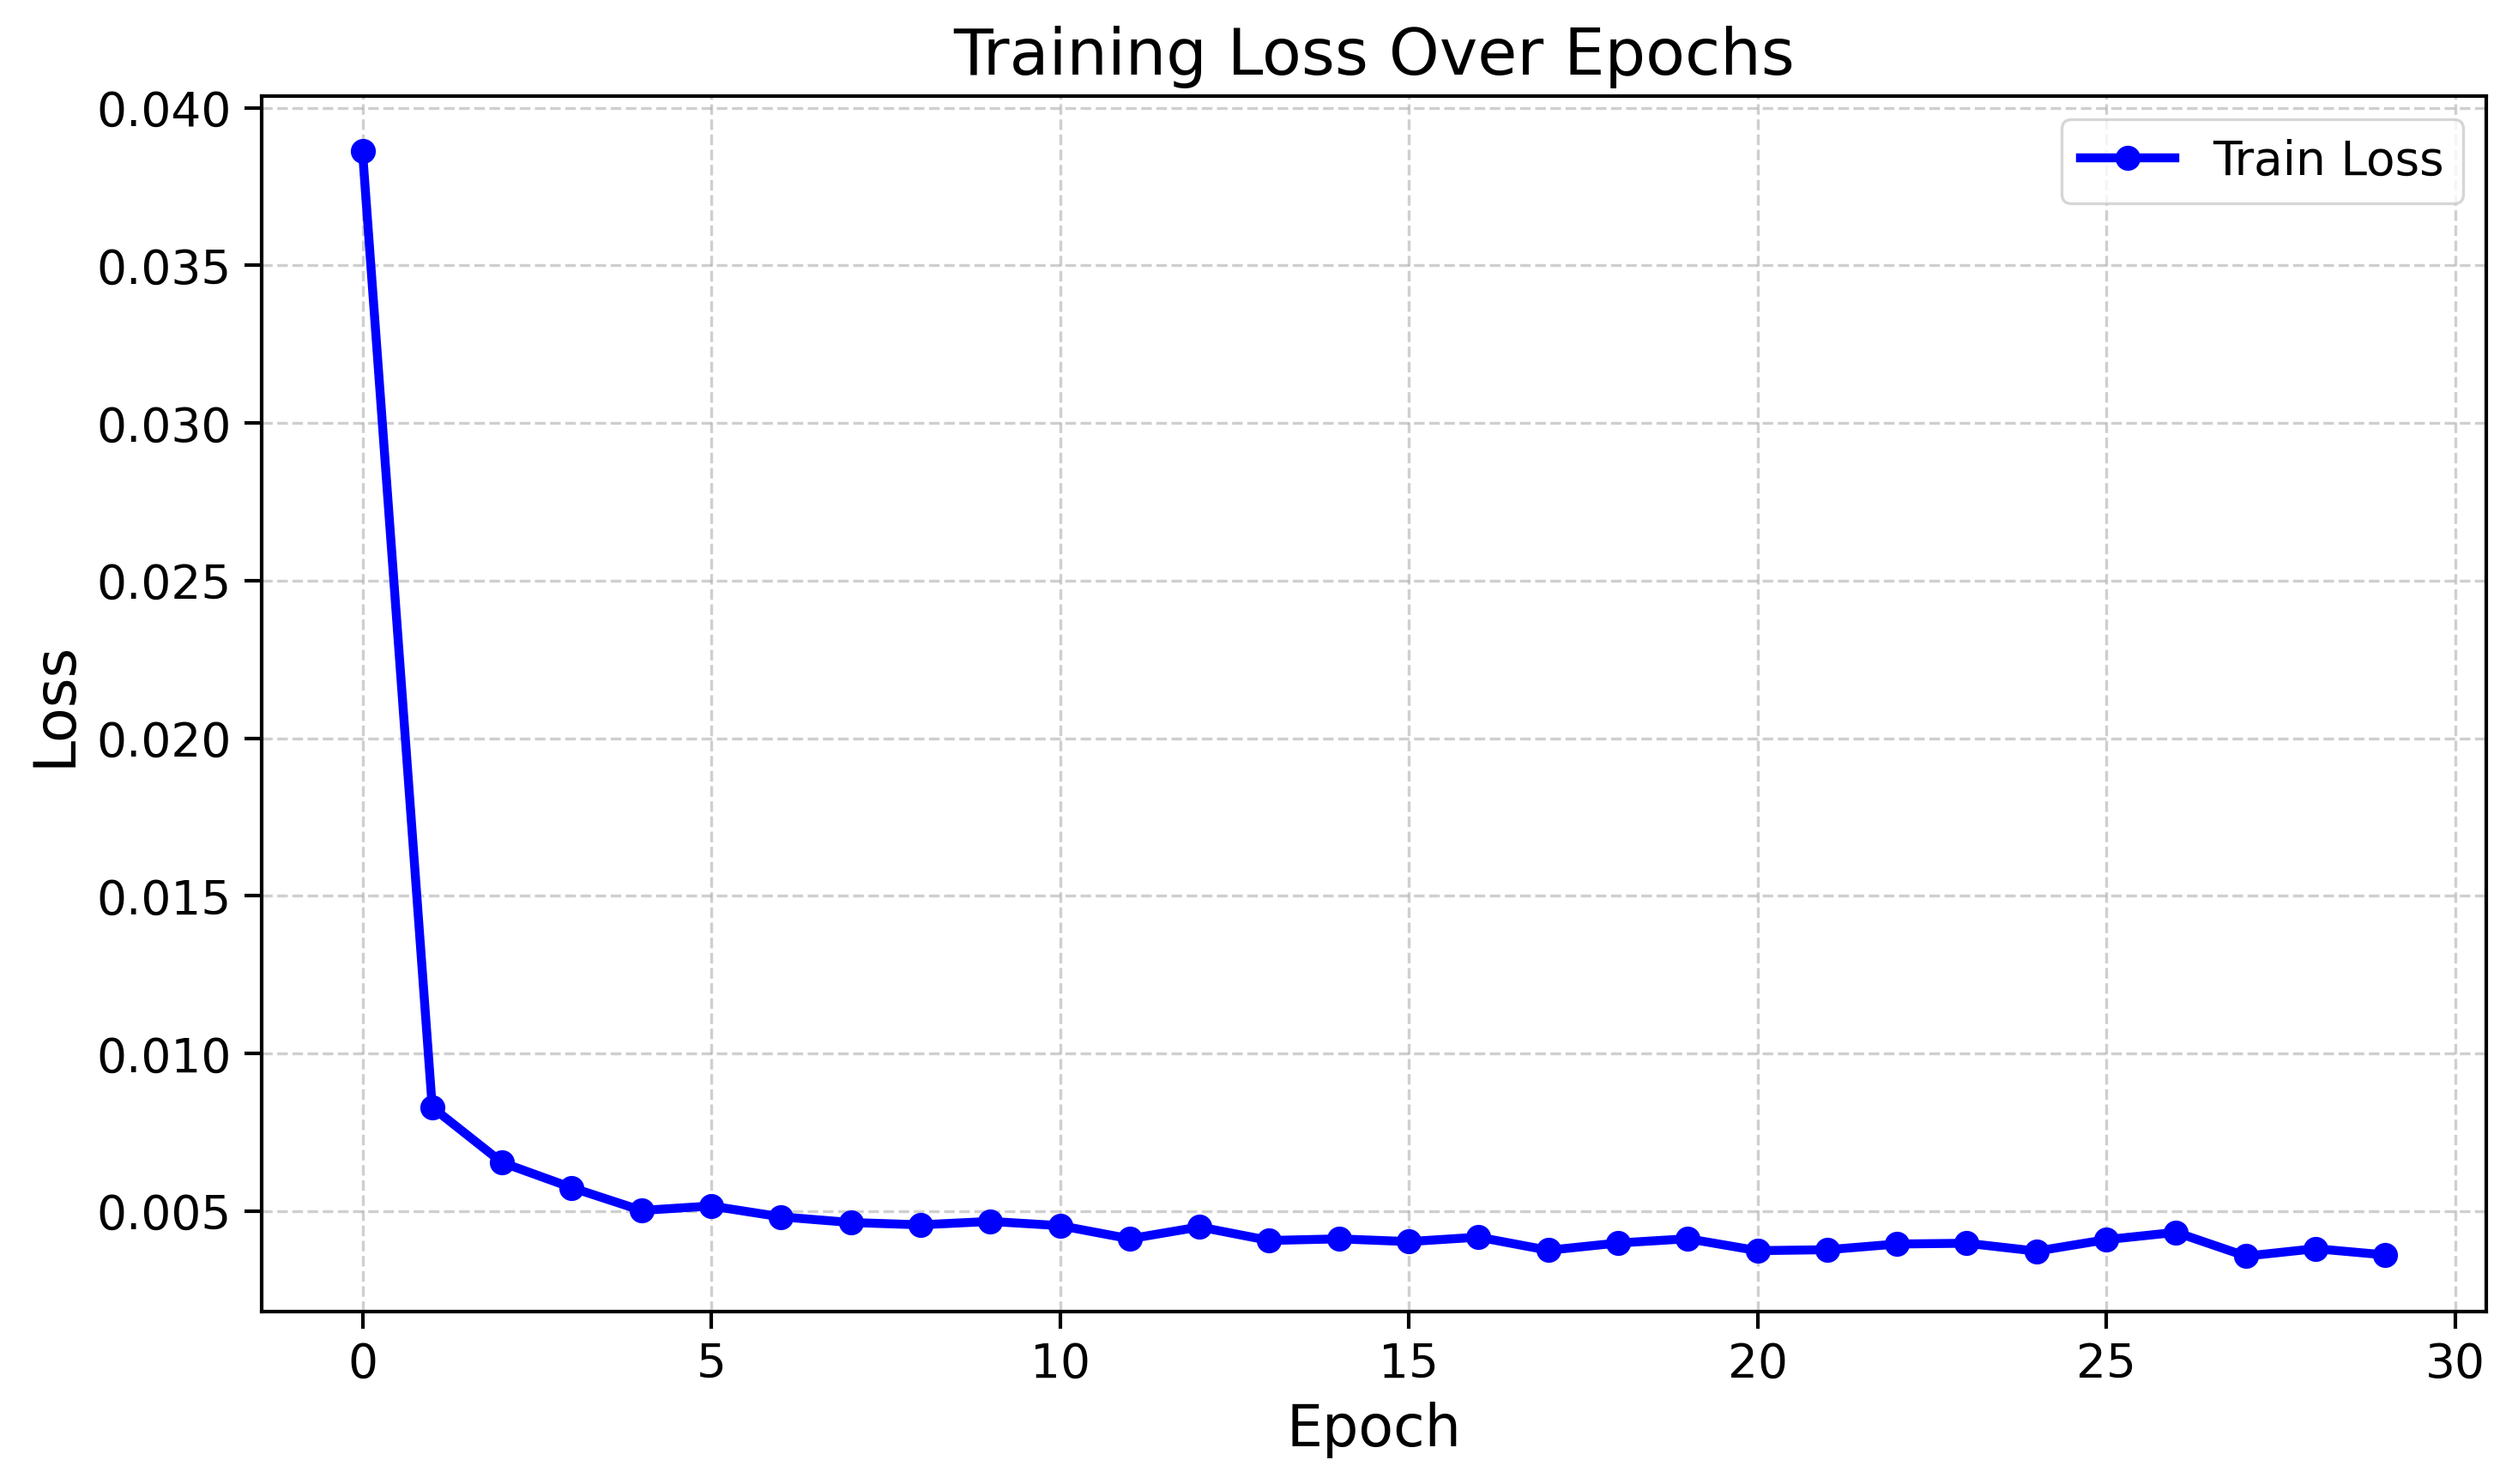

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def plot_train_loss(losses, filename="train_loss_plot.png"):
    sns.set_context("paper", font_scale=1.5)
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(losses, marker='o', linewidth=2.5, markersize=6, label='Train Loss', color='blue')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Training Loss Over Epochs', fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(filename, dpi=600, format='png', bbox_inches='tight')
    plt.show()
plot_train_loss(losses)